In [14]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from PIL import Image, ImageOps

from transformers import ViTFeatureExtractor, ViTForImageClassification

import random
from astropy.io import fits

from skimage import io
import matplotlib.pyplot as plt
from matplotlib import cm

from astropy.visualization import make_lupton_rgb
plt.style.use('dark_background')

In [15]:
class ImageDataset(Dataset):
    """Dataset of Images, Data and Labels"""

    def __init__(self, images, data, labels, transform=None):
        """
        Create a PyTorch dataset from an array of images
		and an array of labels
        """
        self.images = images
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        #return python image given the index
        image = images[idx]
        return image

In [16]:
num_pos = 5
path = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/Data/Sim_complete/'
hdu_list = fits.open(path + 'exp/32.fits')
idx = random.sample(range(len(hdu_list[1].data)), num_pos)
images_pos = hdu_list[1].data[idx,:] 
data_pos = pd.DataFrame(hdu_list[2].data[:][idx])
labels_pos = np.zeros(num_pos, dtype = np.int64)

num_neg = 5
hdu_list = fits.open(path + 'negative_cases.fits')
idx = random.sample(range(len(hdu_list[1].data)), num_neg)
images_neg = hdu_list[1].data[idx,:] 
labels_neg = np.ones(num_neg, dtype = np.int64)
#Data for negatives, all null
num_columns = len(data_pos.columns)
data_neg = np.full((num_neg, num_columns-1), 0)
data_neg = pd.DataFrame(data_neg, columns=['zl/z1', 'm', 'iso', 'E', 'Magni 1'])
last_column = ['Neg']*num_neg
data_neg['ID'] = last_column

images = np.concatenate((images_pos, images_neg)).astype(np.float32)
data = pd.concat([data_pos, data_neg], axis=0)
labels = np.concatenate((labels_pos,labels_neg), dtype = np.int64)

dataset = ImageDataset(images, data, labels, transform=None)

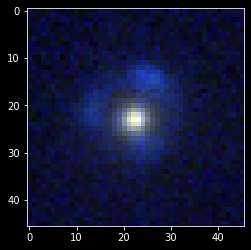

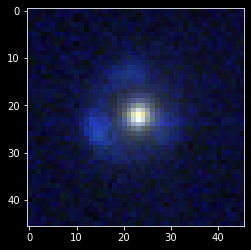

In [32]:
image = dataset[0]

#print(np.mean(image[0]))

image_g = (image[0]-np.mean(image[0]))/ np.std(image[0])
image_r = (image[1]-np.mean(image[1]))/ np.std(image[1])
image_i = (image[2]-np.mean(image[2]))/ np.std(image[2])

#print(np.max(image_g))
#print(np.min(image_g))

image_g = (image_g-np.min(image_g))/ (np.max(image_g) - np.min(image_g))
image_r = (image_r-np.min(image_r))/ (np.max(image_r) - np.min(image_r))
image_i = (image_i-np.min(image_i))/ (np.max(image_i) - np.min(image_i))


new_image = np.empty((3, 46, 46))
new_image[0], new_image[1], new_image[2] = image_i, image_r, image_g

#im = Image.fromarray(np.uint8(cm.gist_earth(image)*255))
#img = Image.fromarray(np.uint8(image)).convert("RGB")
#img = Image.fromarray(img1, "RGB")

new_image = new_image.T
plt.imshow(new_image)
plt.show()

new_image = new_image.transpose(1,0,2)
plt.imshow(new_image)
plt.show()

In [ ]:
img1 = Image.fromarray(255*np.uint8(new_image)).convert("RGB")
plt.imshow(np.asarray(img1))
plt.show()

img1 = Image.fromarray(new_image.astype('uint8'), 'RGB')
plt.imshow(np.asarray(img1))
plt.show()

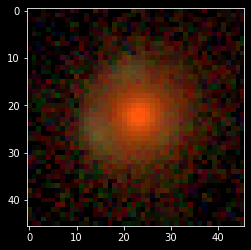

In [20]:
rgb = make_lupton_rgb(dataset[0][2], dataset[0][1], dataset[0][0], Q=11., stretch=40.)
plt.imshow(rgb, aspect='equal')

In [ ]:
class ViTBase16(nn.Module):
    def __init__(self, n_classes, pretrained=False):

        super(ViTBase16
              , self).__init__()

        #self.model = timm.create_model("vit_base_patch16_224", pretrained=False)
        self.model = timm.create_model("vit_base_patch16_224", pretrained=True)
        if pretrained:
            MODEL_PATH = ("C:/Users/zmh001/Documents/vit_model/jx_vit_base_p16_224-80ecf9dd.pth/jx_vit_base_p16_224-80ecf9dd.pth")
            self.model.load_state_dict(torch.load(MODEL_PATH))

        self.model.head = nn.Linear(self.model.head.in_features, n_classes)

    def forward(self, x):

        x = self.model(x)

        return x

    def train_one_epoch(self, train_loader, criterion, optimizer, device):
        # keep track of training loss
        epoch_loss = 0.0
        epoch_accuracy = 0.0

        ###################
        # train the model #
        ###################

        self.model.train()

        for i, (data, target) in tqdm(enumerate(train_loader)):


            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = self.forward(data)
            #output = torch.squeeze(output)
            print("output:")
            print(output)
            print("target")
            print(target)

            print("max of output")
            print(output.argmax(dim=1))

            #target = target.float()
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # Calculate Accuracy
            accuracy = (output.argmax(dim=1) == target).float().mean()
            # update training loss and accuracy
            epoch_loss += loss
            epoch_accuracy += accuracy

            optimizer.step()

        return epoch_loss / len(train_loader), epoch_accuracy / len(train_loader)

    def validate_one_epoch(self, valid_loader, criterion, device):
        # keep track of validation loss
        valid_loss = 0.0
        valid_accuracy = 0.0

        ######################
        # validate the model #
        ######################
        self.model.eval()
        for data, target in tqdm(valid_loader):
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()

            with torch.no_grad():
                # forward pass: compute predicted outputs by passing inputs to the model
                output = self.model(data)
                print("output")
                print(output)
                print("target")
                print(target)
                # calculate the batch loss
                loss = criterion(output, target)
                # Calculate Accuracy
                accuracy = (output.argmax(dim=1) == target).float().mean()
                # update average validation loss and accuracy
                valid_loss += loss
                valid_accuracy += accuracy

        return valid_loss / len(valid_loader), valid_accuracy / len(valid_loader)

In [ ]:
IMG_SIZE = 224
transforms_train = transforms.Compose(
        [
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ]
    )

In [ ]:
num_exp = 31
path_im = 'models/exp/' + str(num_exp)

# load your images into an array called `images` with shape
#  (num_objects, num_bands, height, width)

num_sim, num_neg = 400, 400
path = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/Data/Sim_complete/'
['zl/z1', 'm', 'iso', 'E', 'Magni 1']
# Positive cases
hdu_list = fits.open(path + 'exp/' + str(num_exp) + '.fits')#str(num_exp) + '.fits')
idx = random.sample(range(len(hdu_list[1].data)), num_sim)
sim = hdu_list[1].data[idx,:] 
data_sim = hdu_list[2].data[:][idx] #Simulations parameters data
data_sim = data_sim.astype([('zl/z1', '>f8'), ('m', '>f8'), ('iso', '>f8'), ('E', '>f8'), ('Magni 1', '>f8')])
hdu_list.close()

In [ ]:
print(type(sim))
print(type(data_sim))
print(sim.shape)
print(data_sim.shape)

In [ ]:
print(np.uint8(sim).shape)
#img = Image.fromarray(np.uint8(sim))
img_raw = io.imread(sim)